# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

# Setup

In [2]:
#print(model)
model = HANKModelClass(name='baseline')
#model.print_unpack_varlist()

# Step 1: Steady state

In [3]:
model.find_ss(do_print=True)

steady state found in 17.5 secs
 Q   =   0.6439
 P   =   0.7126
 C Luxury low   =   0.3343
 C Luxury high   =   0.7316
 C Necessity low   =   0.1576
 C necessity high   =   0.2260
 p low   =   0.7858
 p high   =   0.7429
 Z_N   =   0.1400
 Z_L   =   0.5508
 M_N   =   0.3481
 M_L   =   0.1141
 N_L   =   0.7032
 N_N   =   0.4727
 HH_ell   =   1.1968
 wage N  =   0.2770
 wage L  =   0.4302
 par.varphi   =   0.8000
 par.beta   =   0.9864
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =  -0.00000000
Discrepancy in N =   0.00000000


In [4]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [ ]:
fig = plt.figure(figsize=(18,2),dpi=100)
a_max = 500

# a. necessity consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,4,1)
ax.set_title(f'Consumption share, necessities')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c_N[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')

# a. luxury consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,4,2)
ax.set_title(f'Consumption share, luxuries')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.Q*ss.c_L[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')

In [ ]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.0 secs
household problem simulated along transition in 2.7 secs



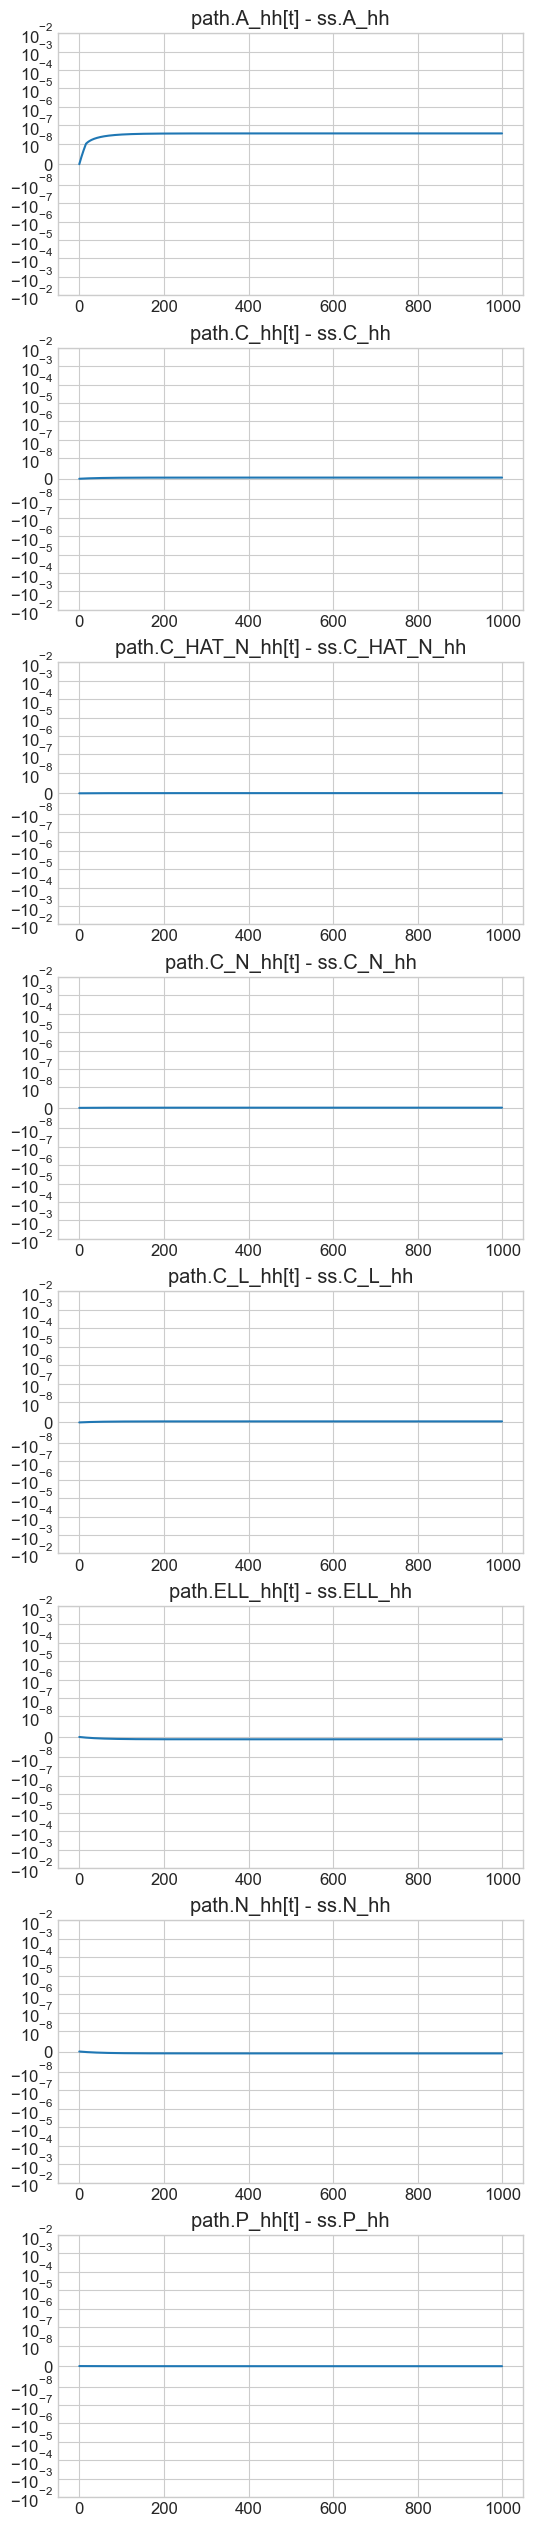

In [5]:
model.test_hh_path()

**Full transition path:**

In [6]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  0.0e+00, max abs.  0.0e+00
d_L            : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
N_N            : t0 =  0.0e+00, max abs.  0.0e+00
N_L            : t0 =  0.0e+00, max abs.  0.0e+00
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 = -2.8e-17, max abs.  2.8e-17
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0

In [ ]:
#model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [8]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 5.46e+00
   1.67e-17 in NKPC_res_N
   1.67e-17 in NKPC_res_L
   5.46e+00 in clearing_A
   1.62e-01 in clearing_N
   2.99e-02 in clearing_C_N


LinAlgError: Singular matrix

## Plot transitions

In [ ]:
paths = ['i','pi_L','pi_N','r','C_N']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

In [ ]:
#model_ = model.copy()
#model_.par_phi_y = 1.0
#model_.find_ss
#model_.compute_jacs()
#model_.find_transition_path()

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()